In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse, parse_qs
from wordcloud import WordCloud  
import re

In [2]:
df = pd.read_csv('./Data/final_dataset.csv')
df

url      type
0       http://1337x.to/torrent/1048648/American-Snipe...    benign
1       http://1337x.to/torrent/1110018/Blackhat-2015-...    benign
2       http://1337x.to/torrent/1122940/Blackhat-2015-...    benign
3       http://1337x.to/torrent/1124395/Fast-and-Furio...    benign
4       http://1337x.to/torrent/1145504/Avengers-Age-o...    benign
...                                                   ...       ...
653041            xbox360.ign.com/objects/850/850402.html  phishing
653042       games.teamxbox.com/xbox-360/1860/Dead-Space/  phishing
653043         www.gamespot.com/xbox360/action/deadspace/  phishing
653044      en.wikipedia.org/wiki/Dead_Space_(video_game)  phishing
653045          www.angelfire.com/goth/devilmaycrytonite/  phishing

[653046 rows x 2 columns]

# General Info

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 653046 entries, 0 to 653045
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     653046 non-null  object
 1   type    653046 non-null  object
dtypes: object(2)
memory usage: 10.0+ MB


In [4]:
df.describe(include="all")

url    type
count                            653046  653046
unique                           653040       5
top     routesinternational.com/air.htm  benign
freq                                  2  428080

# Missing Values

In [5]:
print(f"Missing values: ")
print(df.isnull().sum())

Missing values: 
url     0
type    0
dtype: int64


# Duplicate Rows and URLS

In [6]:
print(f"Duplicate rows out of total rows: {df.duplicated().sum()} / {len(df)}")

duplicate_urls = df[df.duplicated('url', keep=False)]
print(f"Duplicate URLs out of total URLs: {len(duplicate_urls)} / {df['url'].notnull().sum()}")
print(f"Unique URLs out of total URLs: {df['url'].nunique()} / {df['url'].notnull().sum()}")

Duplicate rows out of total rows: 0 / 653046
Duplicate URLs out of total URLs: 12 / 653046
Unique URLs out of total URLs: 653040 / 653046


In [7]:
df[df.duplicated('url', keep=False)]

url      type
283183  memory.loc.gov/ammem/ccmphtml/colahome.html    benign
302328              routesinternational.com/air.htm    benign
305623                 en.wikipedia.org/wiki/E-book    benign
338497     en.wikipedia.org/wiki/Desktop_publishing    benign
349951        groups.yahoo.com/group/Band-in-a-Box/    benign
387170                  ebookstore.sony.com/reader/    benign
611744  memory.loc.gov/ammem/ccmphtml/colahome.html  phishing
614796              routesinternational.com/air.htm  phishing
618687     en.wikipedia.org/wiki/Desktop_publishing  phishing
618721                 en.wikipedia.org/wiki/E-book  phishing
618797                  ebookstore.sony.com/reader/  phishing
627828        groups.yahoo.com/group/Band-in-a-Box/  phishing

# Class distribution

In [8]:
type_counts = df['type'].value_counts()
print("Unique types:", df['type'].nunique())
print('-' * 50)
print(type_counts)

Unique types: 5
--------------------------------------------------
type
benign        428080
defacement     95308
phishing       94092
malware        23645
spam           11921
Name: count, dtype: int64


In [9]:
def plot_type_distribution(df):
    """Plots the distribution of the 'type' column as both a pie chart and a bar chart."""
    type_counts = df['type'].value_counts()
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Pie Chart
    axes[0].pie(type_counts, labels=type_counts.index, autopct='%1.1f%%', 
                startangle=140, colors=plt.cm.Paired.colors)
    axes[0].set_title("Distribution of Types (Pie Chart)")
    
    # Bar Chart
    colors = plt.cm.Paired.colors[:len(type_counts)]  # Assign unique colors
    axes[1].bar(type_counts.index, type_counts.values, color=colors)
    axes[1].set_title("Distribution of Types (Bar Chart)")
    axes[1].set_xlabel("Type")
    axes[1].set_ylabel("Count")
    axes[1].tick_params(axis='x', rotation=45)  # Rotate x-labels for readability
    
    plt.tight_layout()
    plt.show()

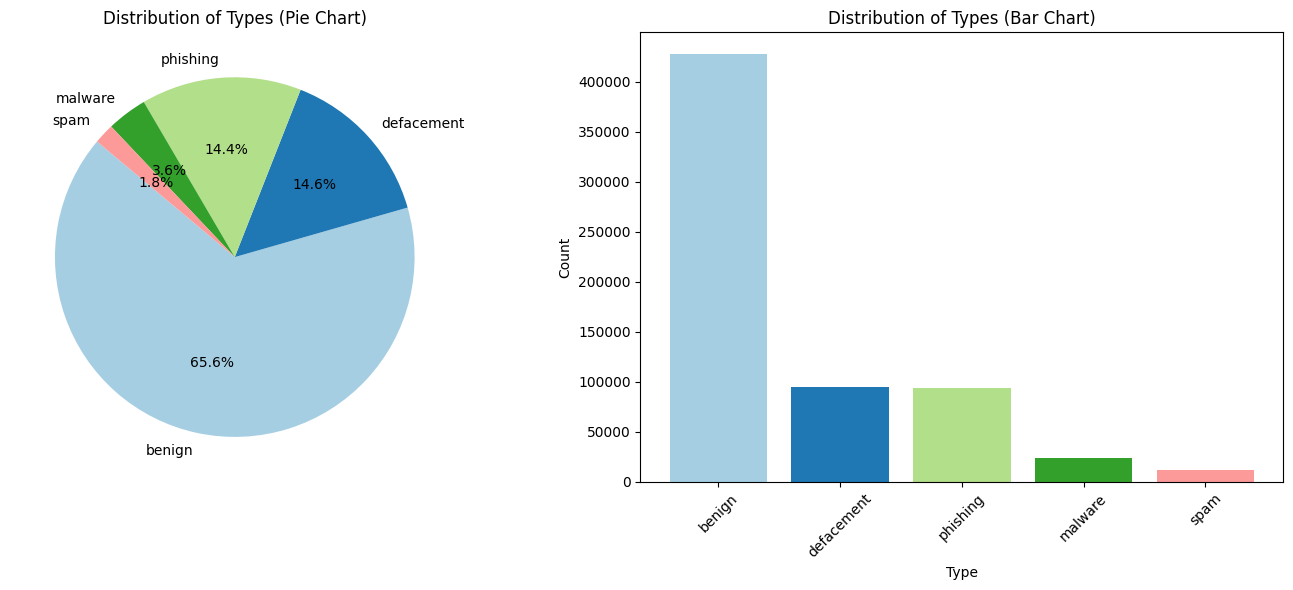

In [10]:
plot_type_distribution(df)

# Extracting URL Features

In [11]:
def extract_url_features(url, url_type=None):
    try:
        # Ensure the URL has a scheme (default to 'https')
        if not urlparse(url).scheme:
            url = 'https://' + url  # Prepend https if missing

        parsed = urlparse(url)
        path_segments = parsed.path.strip('/').split('/')
        domain_parts = parsed.netloc.split('.')

        return {
            'url': url,  # Append original URL
            'type': url_type if url_type else 'unknown',  # Append URL type
            'scheme': parsed.scheme if parsed.scheme else 'unknown',
            'domain': parsed.netloc if parsed.netloc else 'unknown',
            'subdomain': domain_parts[0] if len(domain_parts) > 2 else 'none',
            'top_level_domain': domain_parts[-1] if len(domain_parts) > 1 else 'unknown',
            'path': parsed.path if parsed.path else '/',
            'path_length': len(parsed.path),
            'num_path_segments': len(path_segments) if path_segments != [''] else 0,
            'query_params': len(parse_qs(parsed.query)),
            'num_query_params': len(parsed.query.split('&')) if parsed.query else 0,
            'has_https': int(parsed.scheme == 'https'),
            'file_extension': path_segments[-1].split('.')[-1] if '.' in path_segments[-1] else 'none',
            'has_fragment': int(bool(parsed.fragment)),
            'has_special_chars_in_path': int(bool(re.search(r'[@#$%^&*]', parsed.path))),
            'has_port': int(bool(parsed.port)),
            'port_number': parsed.port if parsed.port else 0,
            'is_ip_address': int(bool(re.match(r'^\d{1,3}(\.\d{1,3}){3}$', parsed.netloc)))
        }
    except Exception as e:
        print(f"Error processing URL: {url} -> {e}")
        return None

In [12]:
SAMPLE_SIZE = len(df)  
url_sample = df[['url', 'type']].sample(SAMPLE_SIZE, random_state=42)
url_features = pd.json_normalize(url_sample.apply(lambda x: extract_url_features(x['url'], x['type']), axis=1).dropna())
url_features

Error processing URL: https://ÐÍ³ÕÙ»®:õGw#9ø£prÝU\On~Àòûu3ÐÒhöØ±Ú9Ìe JÔöw¿ -> Port could not be cast to integer value as 'õ\x0fGw'
Error processing URL: https://½<+U½¹1[1"Kfw§¿âÎ¸pWb®ÜÜ|¾Ö·ff¦o6QõFõTmK&0Û¤RÍÌPü.Ò<'BÉ@-óàYN\¦~7J¡*Èú=ÙU ^>R~@O· -> Invalid IPv6 URL
Error processing URL: https://^oð]Â|¬|hõElòdy^Å~fb_jH0TRËR¯ÆÏa­ùº2)îè®£Y[@ø{ç­Ó9{ëmOfD¥Î3ÿ5··®/©×J -> '@ø{ç\xadÓ9{ëmOfD¥Î\x9e3\x82ÿ\x125··®' does not appear to be an IPv4 or IPv6 address
Error processing URL: https://oÍÑOwEuÊÚÃß=nËß[j{2%.tñø­½½qx½NºPmx$Aì&ÝIhÂéc¶A9®cì3ßyiÚý~JÍf]$ö M¸°;xÃu0IÅ@xõe^cÃ ¸´ÞO7B~FrØ\<kÅb{T!Ìé	r?kX-YÇS@T)LeaÃ}°¡ùï4ºkïá2¢kEì¬ôfsçË×ÛQìê{o£UÜ§D©l½±±äâqôó¼-â0èÙ¦kvîdàQÎé6°Ò¼© -> 'j{2%.tñ\x9c\x17ø\x91\xad½½qx½NºPmx$Aì&\x9eÝ\x88\x9bIh\x8e\x80Âéc¶A9®c\x90\x02ì3ßyiÚ\x9a\x8cý~\x88\x06\x06JÍf' does not appear to be an IPv4 or IPv6 address
Error processing URL: https://=Rãmôj³{è!ÀM¶6<N>w¼Cf£]4ÍnÝÌ

url        type scheme  \
0       https://longshoreshippingnews.com/tag/canadian...      benign  https   
1       http://rfmhvac.com/home/1-home-page/1-rf-merdi...  defacement   http   
2                     https://0rkut-3d-2011.blogspot.com/      benign  https   
3       http://elitedaily.com/news/world/when-words-fa...      benign   http   
4         https://sheetmusicplus.com/s?q=Philippe+Gaubert      benign  https   
...                                                   ...         ...    ...   
653021  https://www.embeddedstar.com/press/content/200...    phishing  https   
653022              https://myspace.com/isaacjamestheband      benign  https   
653023  https://oulton.com/cwa/newsns.nsf/a6040306c38a...      benign  https   
653024  http://shicaifanxin.cn/index.php?s=video/searc...     malware   http   
653025  http://vinno.co.th/index.php?option=com_contac...  defacement   http   

                            domain      subdomain top_level_domain  \
0        longshoreshippingnews.com           none              com   
1                      rfmhvac.com           none              com   
2       0rkut-3d-2011.blogspot.com  0rkut-3d-2011              com   
3                   elitedaily.com           none              com   
4               sheetmusicplus.com           none              com   
...                            ...            ...              ...   
653021        www.embeddedstar.com            www              com   
653022                 myspace.com           none              com   
653023                  oulton.com           none              com   
653024             shicaifanxin.cn           none               cn   
653025                 vinno.co.th          vinno               th   

                                                     path  path_length  \
0                         /tag/canadian-national-railway/           31   
1       /home/1-home-page/1-rf-merdian-heating-and-air...           59   
2                                                       /            1   
3       /news/world/when-words-fail-pictures-speak-the...           84   
4                                                      /s            2   
...                                                   ...          ...   
653021          /press/content/2003/10/embedded10764.html           41   
653022                                 /isaacjamestheband           18   
653023  /cwa/newsns.nsf/a6040306c38ac84d85256588001c24...           94   
653024                                         /index.php           10   
653025                                         /index.php           10   

        num_path_segments  query_params  num_query_params  has_https  \
0                       2             0                 0          1   
1                       3             0                 0          0   
2                       0             0                 0          1   
3                       4             0                 0          0   
4                       1             1                 1          1   
...                   ...           ...               ...        ...   
653021                  5             0                 0          1   
653022                  1             0                 0          1   
653023                  4             0                 0          1   
653024                  1             1                 1          0   
653025                  1             4                 4          0   

       file_extension  has_fragment  has_special_chars_in_path  has_port  \
0                none             0                          0         0   
1                none             0                          0         0   
2                none             0                          0         0   
3                none             0                          0         0   
4                none             0                          0         0   
...               ...           ...       

Unique Domains: 197410
**************************************************
General Top 10 domains
domain
en.wikipedia.org        13206
youtube.com              8617
facebook.com             7735
amazon.com               4618
imdb.com                 3470
linkedin.com             3426
tools.ietf.org           3190
myspace.com              3015
mitsui-jyuku.mixh.jp     2879
mylife.com               2822
Name: count, dtype: int64
**************************************************


C:\Users\Areeba\AppData\Local\Temp\ipykernel_12956\3841985443.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=domain_counts.index, y=domain_counts.values, ax=axes[1], palette=colors)


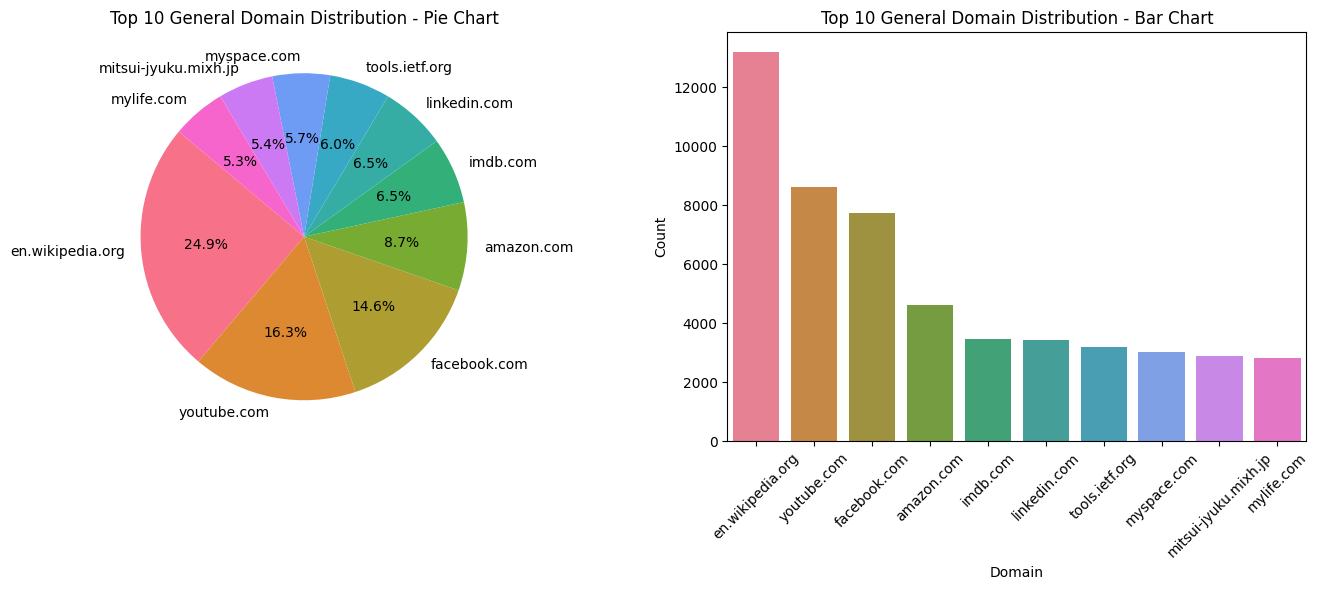

In [13]:
unique_domain_counts = url_features['domain'].nunique()
print("Unique Domains:", unique_domain_counts)
print('*' * 50)

top_k = 10
print(f'General Top {top_k} domains')
print(url_features['domain'].value_counts().head(10))
print('*' * 50)

domain_counts = url_features['domain'].value_counts().nlargest(top_k)

# Define colors
colors = sns.color_palette("husl", len(domain_counts))

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Pie Chart
axes[0].pie(domain_counts, labels=domain_counts.index, autopct='%1.1f%%', colors=colors, startangle=140)
axes[0].set_title(f'Top {top_k} General Domain Distribution - Pie Chart')

# Bar Chart
sns.barplot(x=domain_counts.index, y=domain_counts.values, ax=axes[1], palette=colors)
axes[1].set_title(f'Top {top_k} General Domain Distribution - Bar Chart')
axes[1].set_ylabel('Count')
axes[1].set_xlabel('Domain')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [14]:
def plot_grouped_distribution(df, column, top_k=10):
    grouped = df.groupby('type')[column].value_counts().reset_index(name='count')
    unique_types = df['type'].unique()
    
    # Define colors
    colors = sns.color_palette("husl", len(unique_types))
    
    # Create subplots
    fig, axes = plt.subplots(len(unique_types), 2, figsize=(14, 6 * len(unique_types)))
    
    for i, t in enumerate(unique_types):
        domain_counts = grouped[grouped['type'] == t].nlargest(top_k, 'count')
        
        # Pie Chart
        axes[i, 0].pie(domain_counts['count'], labels=domain_counts[column], autopct='%1.1f%%', colors=colors, startangle=140)
        axes[i, 0].set_title(f'Top {top_k} {column} Distribution for {t} - Pie Chart')
        
        # Bar Chart
        sns.barplot(x=domain_counts[column], y=domain_counts['count'], ax=axes[i, 1], palette=colors)
        axes[i, 1].set_title(f'Top {top_k} {column} Distribution for {t} - Bar Chart')
        axes[i, 1].set_ylabel('Count')
        axes[i, 1].set_xlabel(column.capitalize())
        axes[i, 1].tick_params(axis='x', rotation=45)
    
    # Show plot
    plt.tight_layout()
    plt.show()

C:\Users\Areeba\AppData\Local\Temp\ipykernel_12956\2460121065.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=domain_counts[column], y=domain_counts['count'], ax=axes[i, 1], palette=colors)
C:\Users\Areeba\AppData\Local\Temp\ipykernel_12956\2460121065.py:19: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=domain_counts[column], y=domain_counts['count'], ax=axes[i, 1], palette=colors)
C:\Users\Areeba\AppData\Local\Temp\ipykernel_12956\2460121065.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=domain_counts[column], y=domain_counts['count'], ax=axes[i, 1], palette=colors)
C:\Users\Ar

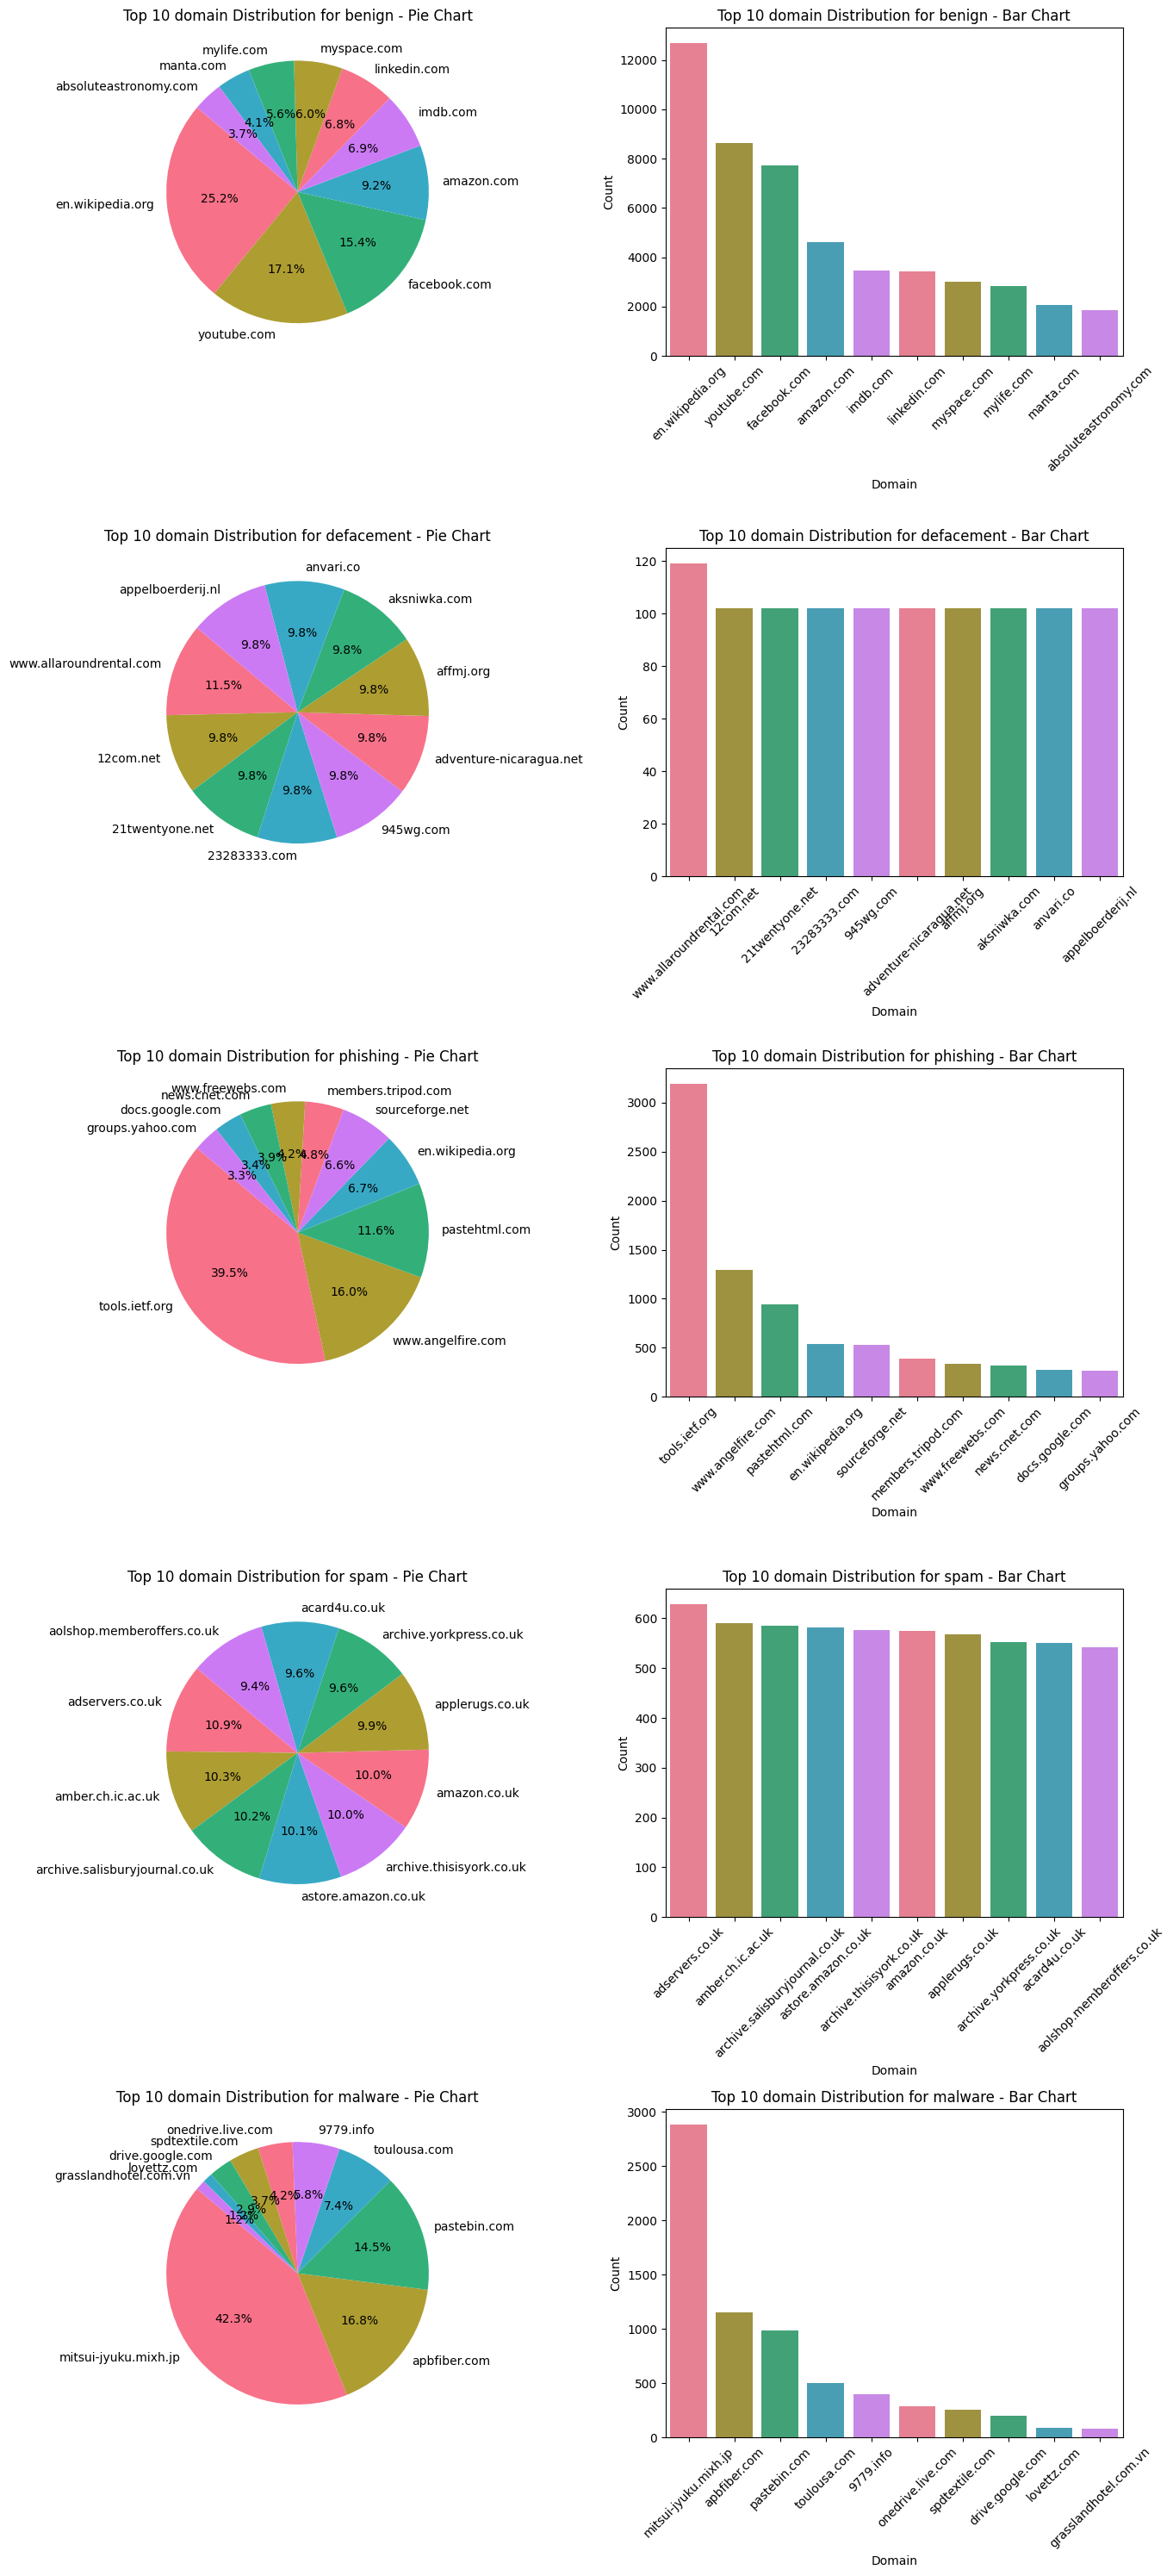

In [15]:
plot_grouped_distribution(url_features, 'domain')

C:\Users\Areeba\AppData\Local\Temp\ipykernel_12956\2460121065.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=domain_counts[column], y=domain_counts['count'], ax=axes[i, 1], palette=colors)
C:\Users\Areeba\AppData\Local\Temp\ipykernel_12956\2460121065.py:19: UserWarning: 
The palette list has fewer values (5) than needed (10) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x=domain_counts[column], y=domain_counts['count'], ax=axes[i, 1], palette=colors)
C:\Users\Areeba\AppData\Local\Temp\ipykernel_12956\2460121065.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=domain_counts[column], y=domain_counts['count'], ax=axes[i, 1], palette=colors)
C:\Users\Ar

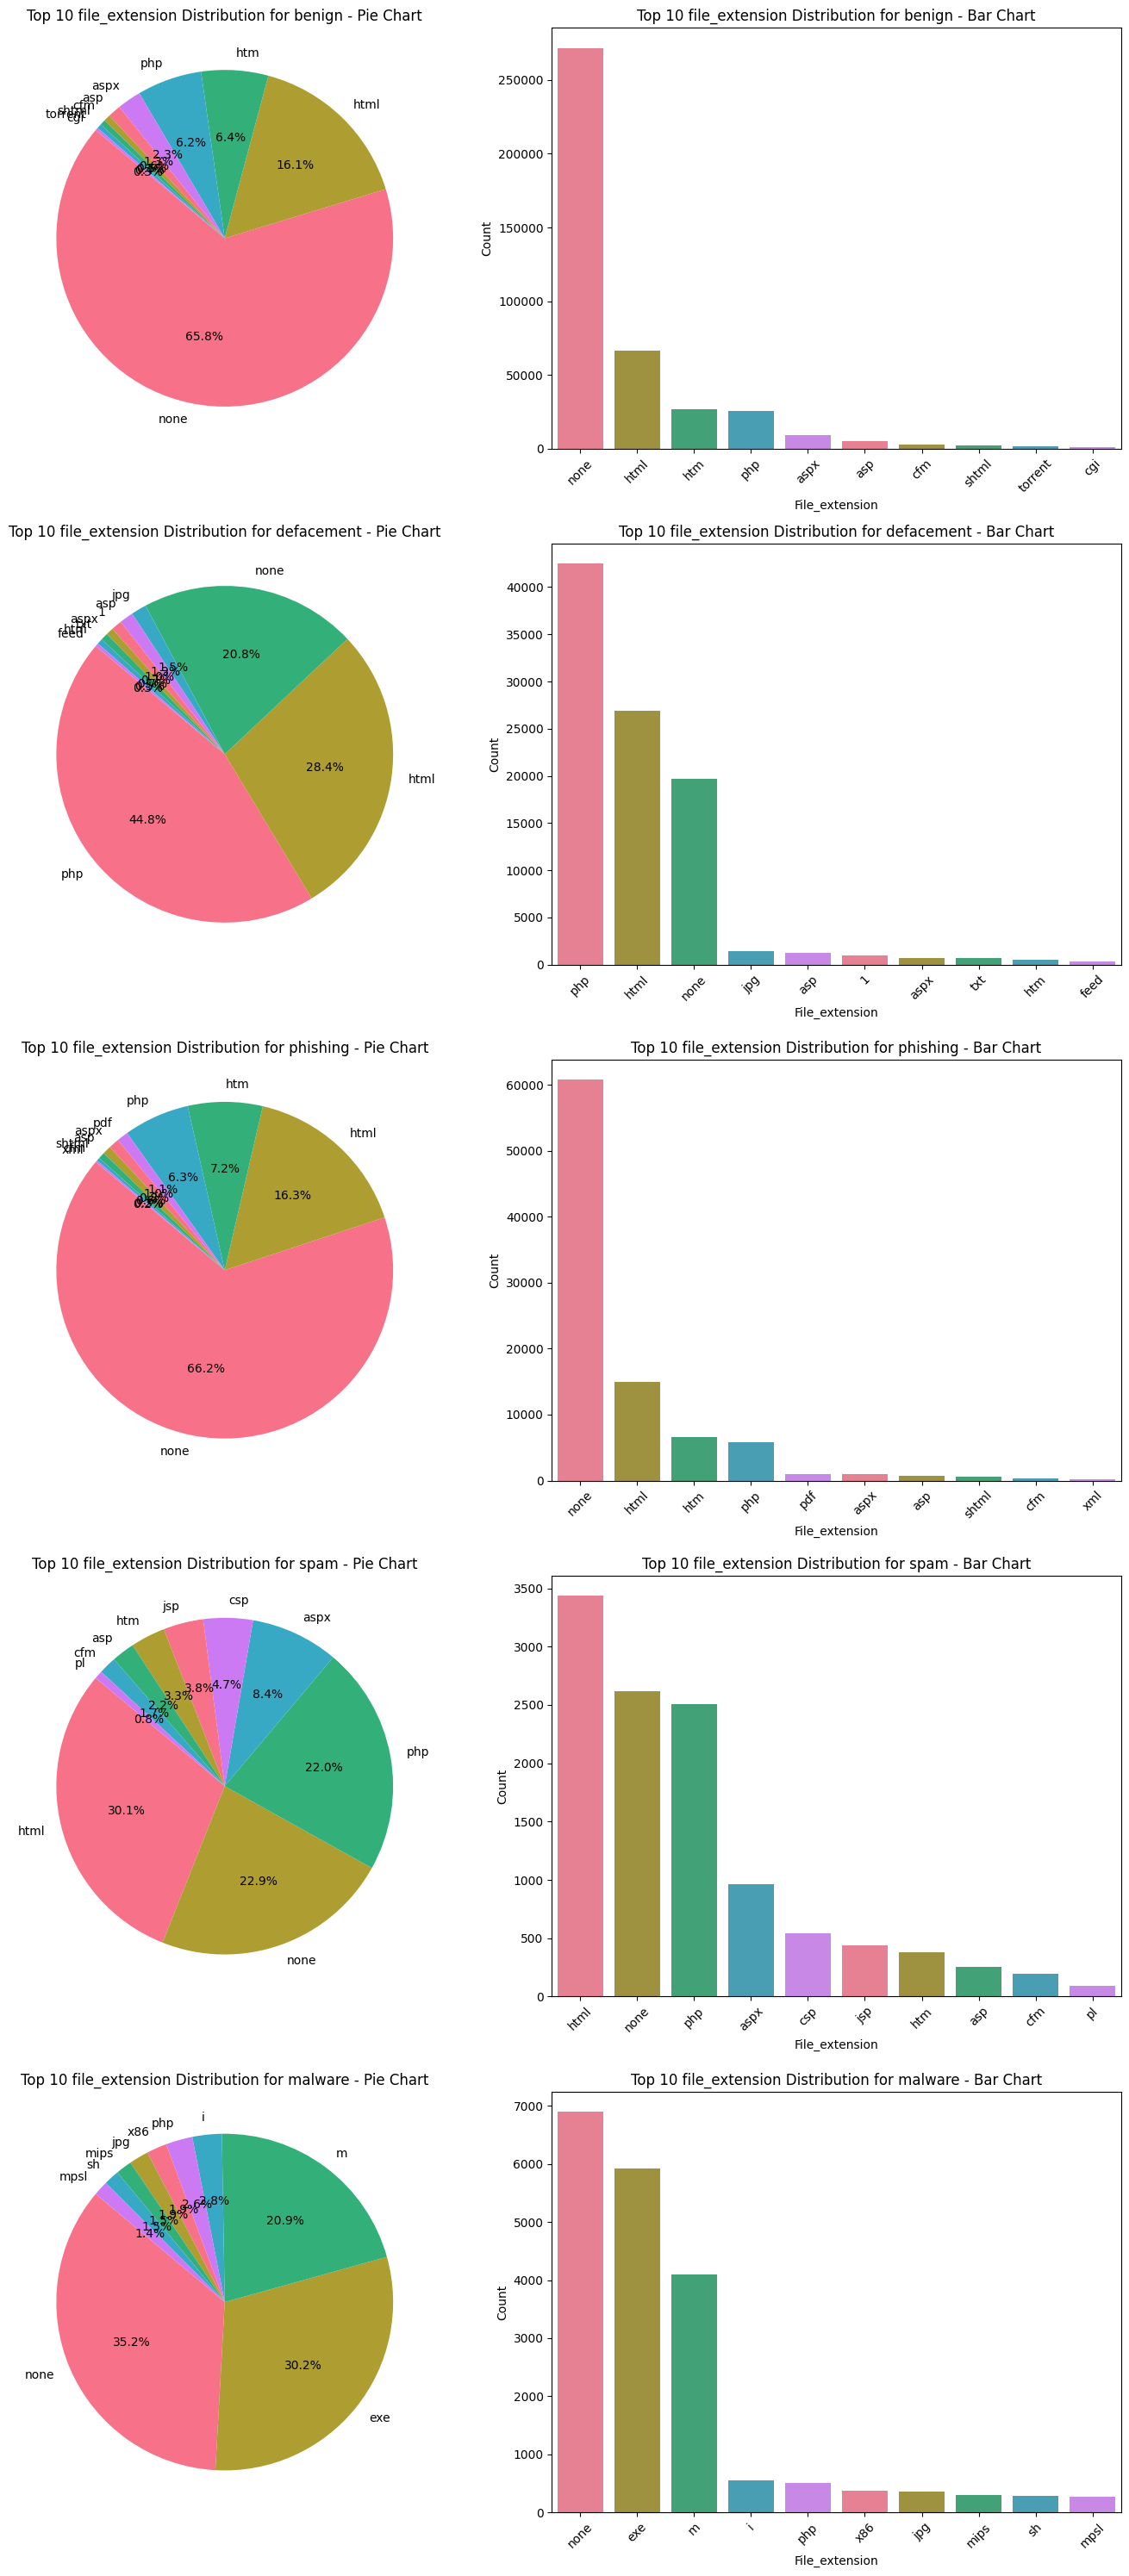

In [16]:
plot_grouped_distribution(url_features, 'file_extension')

In [17]:
def plot_wordcloud(df, column):
    grouped = df.groupby('type')[column].apply(lambda x: ' '.join(x)).reset_index()
    unique_types = df['type'].unique()
    
    fig, axes = plt.subplots(len(unique_types), 1, figsize=(10, 6 * len(unique_types)))
    
    if len(unique_types) == 1:
        axes = [axes]
    
    for i, t in enumerate(unique_types):
        text = grouped[grouped['type'] == t][column].values[0] if not grouped[grouped['type'] == t].empty else ''
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
        
        axes[i].imshow(wordcloud, interpolation='bilinear')
        axes[i].axis("off")
        axes[i].set_title(f'Word Cloud of {column} for {t}')
    
    plt.tight_layout()
    plt.show()

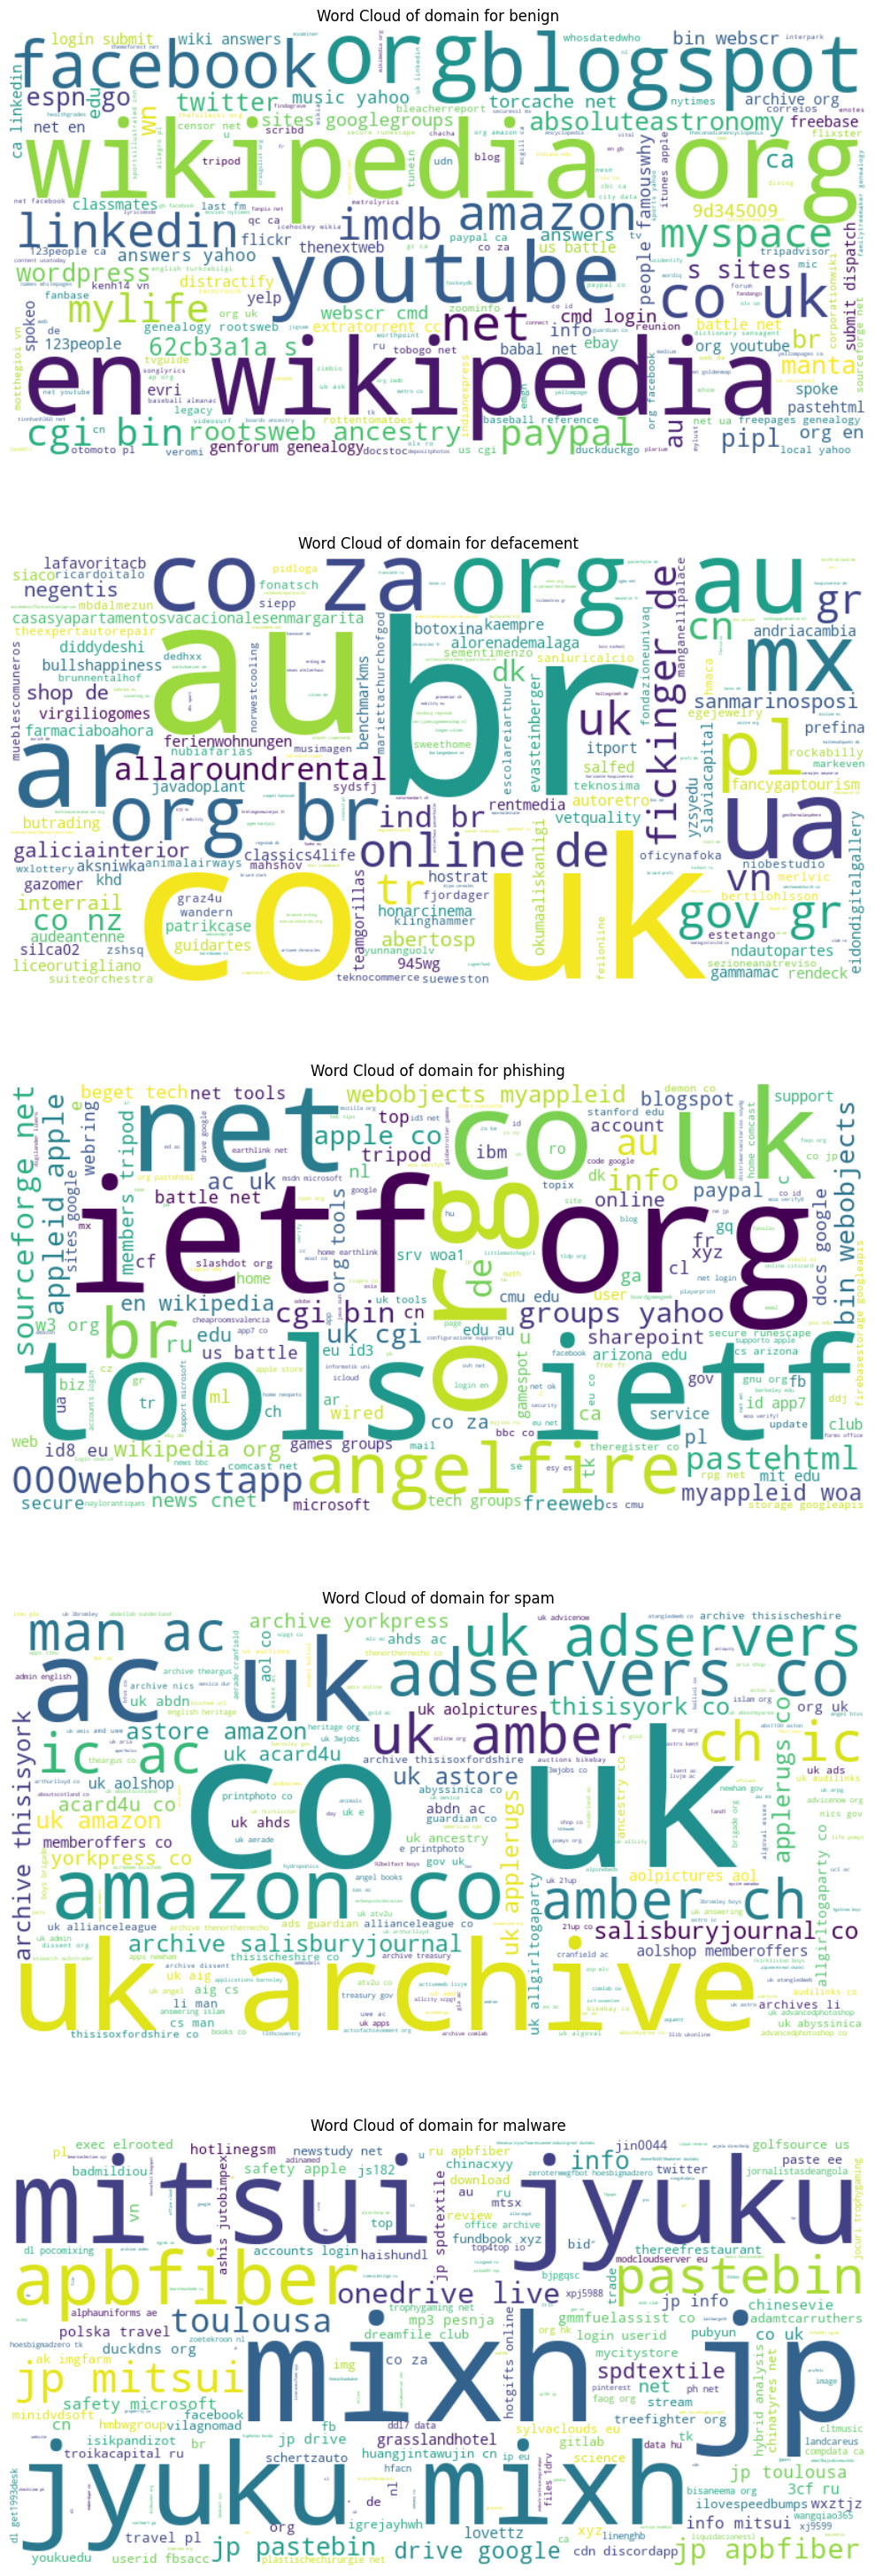

In [18]:
plot_wordcloud(url_features, 'domain')

# Plot for File Extension

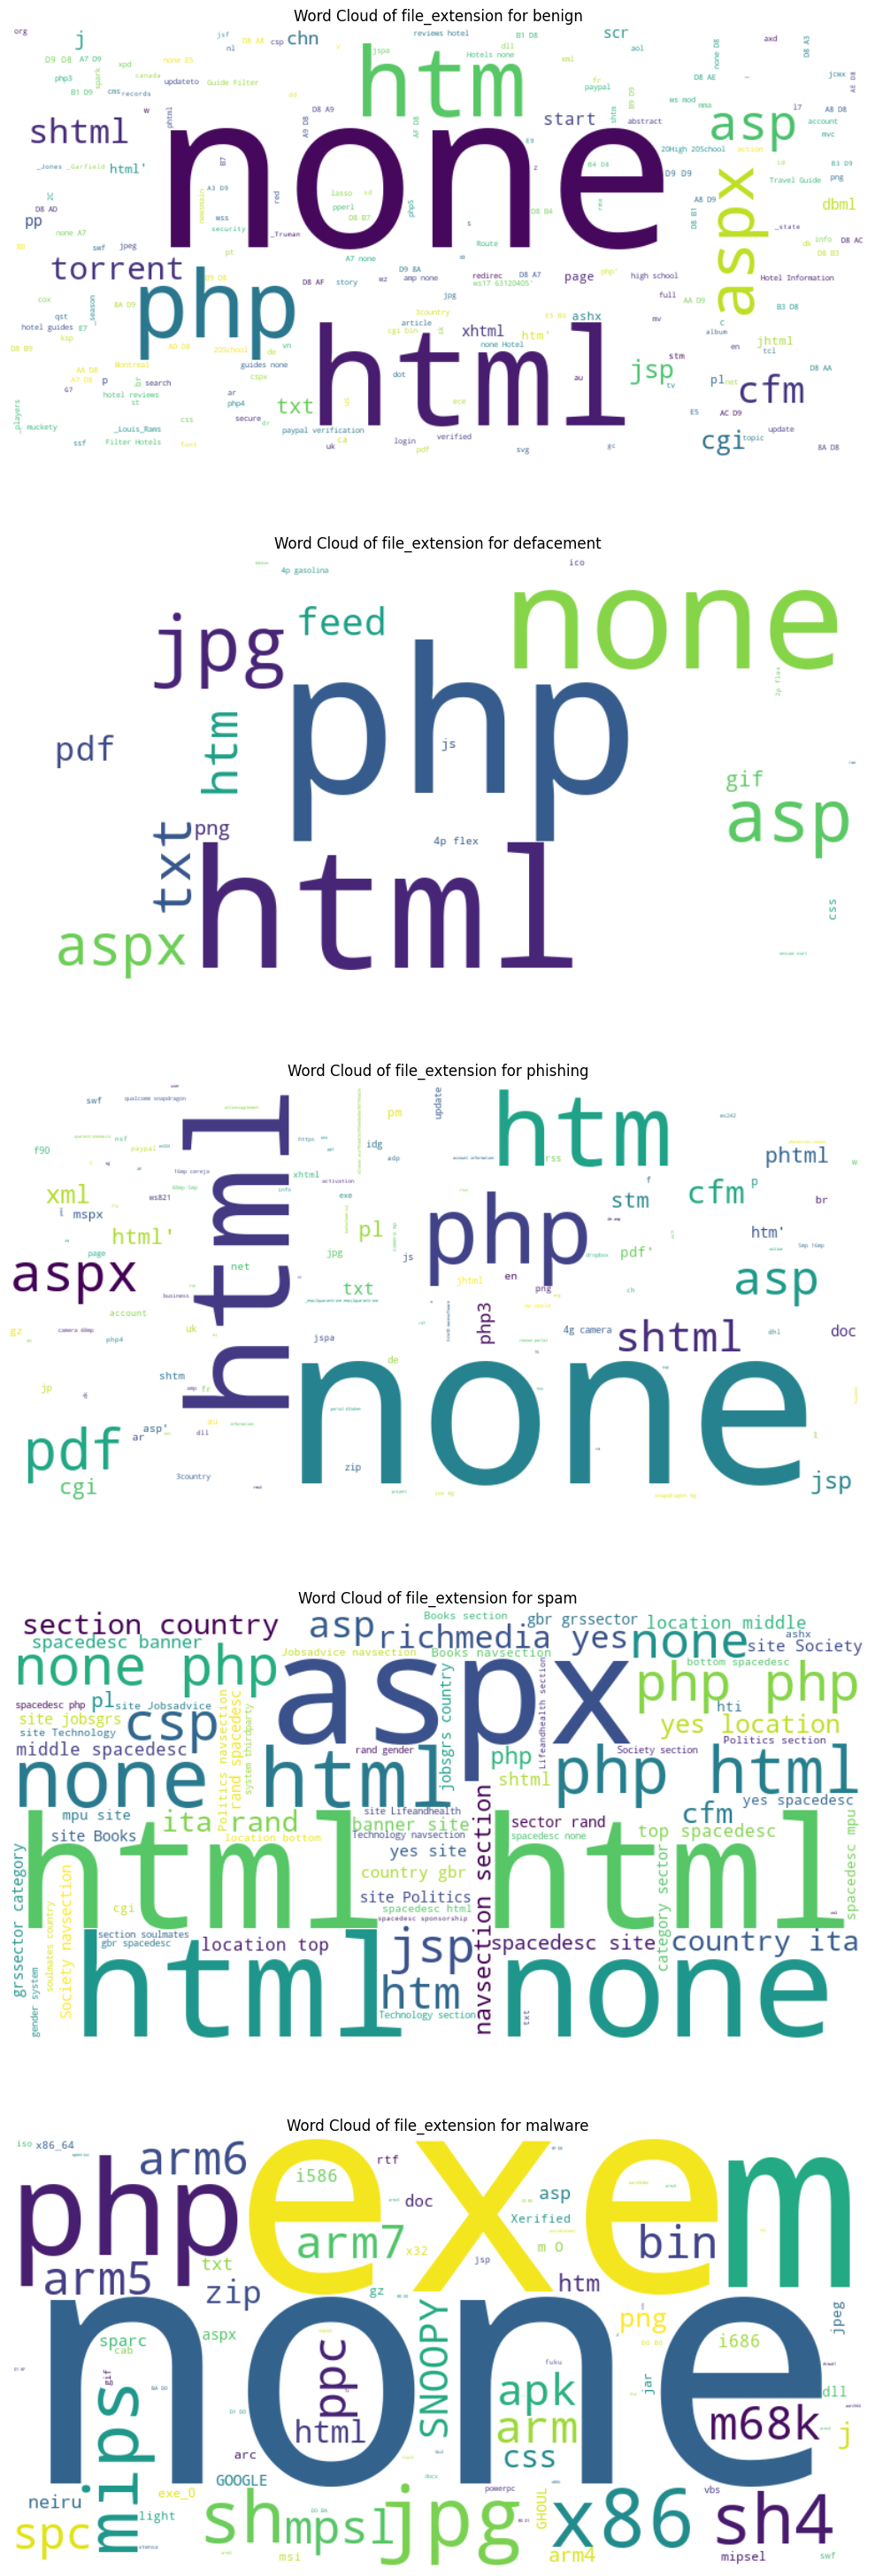

In [19]:
plot_wordcloud(url_features, 'file_extension')

In [20]:
url_features

url        type scheme  \
0       https://longshoreshippingnews.com/tag/canadian...      benign  https   
1       http://rfmhvac.com/home/1-home-page/1-rf-merdi...  defacement   http   
2                     https://0rkut-3d-2011.blogspot.com/      benign  https   
3       http://elitedaily.com/news/world/when-words-fa...      benign   http   
4         https://sheetmusicplus.com/s?q=Philippe+Gaubert      benign  https   
...                                                   ...         ...    ...   
653021  https://www.embeddedstar.com/press/content/200...    phishing  https   
653022              https://myspace.com/isaacjamestheband      benign  https   
653023  https://oulton.com/cwa/newsns.nsf/a6040306c38a...      benign  https   
653024  http://shicaifanxin.cn/index.php?s=video/searc...     malware   http   
653025  http://vinno.co.th/index.php?option=com_contac...  defacement   http   

                            domain      subdomain top_level_domain  \
0        longshoreshippingnews.com           none              com   
1                      rfmhvac.com           none              com   
2       0rkut-3d-2011.blogspot.com  0rkut-3d-2011              com   
3                   elitedaily.com           none              com   
4               sheetmusicplus.com           none              com   
...                            ...            ...              ...   
653021        www.embeddedstar.com            www              com   
653022                 myspace.com           none              com   
653023                  oulton.com           none              com   
653024             shicaifanxin.cn           none               cn   
653025                 vinno.co.th          vinno               th   

                                                     path  path_length  \
0                         /tag/canadian-national-railway/           31   
1       /home/1-home-page/1-rf-merdian-heating-and-air...           59   
2                                                       /            1   
3       /news/world/when-words-fail-pictures-speak-the...           84   
4                                                      /s            2   
...                                                   ...          ...   
653021          /press/content/2003/10/embedded10764.html           41   
653022                                 /isaacjamestheband           18   
653023  /cwa/newsns.nsf/a6040306c38ac84d85256588001c24...           94   
653024                                         /index.php           10   
653025                                         /index.php           10   

        num_path_segments  query_params  num_query_params  has_https  \
0                       2             0                 0          1   
1                       3             0                 0          0   
2                       0             0                 0          1   
3                       4             0                 0          0   
4                       1             1                 1          1   
...                   ...           ...               ...        ...   
653021                  5             0                 0          1   
653022                  1             0                 0          1   
653023                  4             0                 0          1   
653024                  1             1                 1          0   
653025                  1             4                 4          0   

       file_extension  has_fragment  has_special_chars_in_path  has_port  \
0                none             0                          0         0   
1                none             0                          0         0   
2                none             0                          0         0   
3                none             0                          0         0   
4                none             0                          0         0   
...               ...           ...       

# Handling Class Imbalance

In [ ]:
def balance_dataset(df, target_column):
    value_counts = df[target_column].value_counts()
    min_class_count = value_counts.min()
    
    # If all classes are already balanced, return the original dataframe
    if value_counts.nunique() == 1:
        return df
    
    balanced_data = []
    for cls in value_counts.index:
        subset = df[df[target_column] == cls]
        sampled_subset = subset.sample(min_class_count, replace=True, random_state=42)
        balanced_data.append(sampled_subset)
    
    return pd.concat(balanced_data, ignore_index=True)

In [23]:
df = balance_dataset(url_features, 'type')
df

url    type scheme  \
0        https://ethnicelebs.com/eddie-anderson-comedian  benign  https   
1      https://closinglogos.com/page/Sony+Pictures+Ho...  benign  https   
2      https://terezowens.com/golfer-greg-norman-tryi...  benign  https   
3                            https://americannortel.com/  benign  https   
4                                   https://welding.org/  benign  https   
...                                                  ...     ...    ...   
59600  http://archives.li.man.ac.uk/ead/search/?opera...    spam   http   
59601    http://amber.ch.ic.ac.uk/archive/all/10253.html    spam   http   
59602  http://archive.thisischeshire.co.uk/2000/1/28/...    spam   http   
59603  http://ads.guardian.co.uk/click.ng/Params.rich...    spam   http   
59604    http://ancestry.co.uk/search/db.aspx?dbid=22261    spam   http   

                             domain subdomain top_level_domain  \
0                   ethnicelebs.com      none              com   
1                  closinglogos.com      none              com   
2                    terezowens.com      none              com   
3                americannortel.com      none              com   
4                       welding.org      none              org   
...                             ...       ...              ...   
59600         archives.li.man.ac.uk  archives               uk   
59601             amber.ch.ic.ac.uk     amber               uk   
59602  archive.thisischeshire.co.uk   archive               uk   
59603            ads.guardian.co.uk       ads               uk   
59604                ancestry.co.uk  ancestry               uk   

                                                    path  path_length  \
0                               /eddie-anderson-comedian           24   
1      /page/Sony+Pictures+Home+Entertainment+Warning...           53   
2      /golfer-greg-norman-trying-to-unload-55-millio...           54   
3                                                      /            1   
4                                                      /            1   
...                                                  ...          ...   
59600                                       /ead/search/           12   
59601                            /archive/all/10253.html           23   
59602                             /2000/1/28/225238.html           22   
59603  /click.ng/Params.richmedia=yes&location=middle...          128   
59604                                    /search/db.aspx           15   

       num_path_segments  query_params  num_query_params  has_https  \
0                      1             0                 0          1   
1                      2             0                 0          1   
2                      1             0                 0          1   
3                      0             0                 0          1   
4                      0             0                 0          1   
...                  ...           ...               ...        ...   
59600                  2             6                 6          0   
59601                  3             0                 0          0   
59602                  4             0                 0          0   
59603                  2             0                 0          0   
59604                  2             1                 1          0   

                                          file_extension  has_fragment  \
0                                                   none             0   
1                                                   none             0   
2                                                   none             0   
3                                                   none             0   
4                                                   none             0   
...                                                  ...           ...   
59600                                               none             0   
59601                                

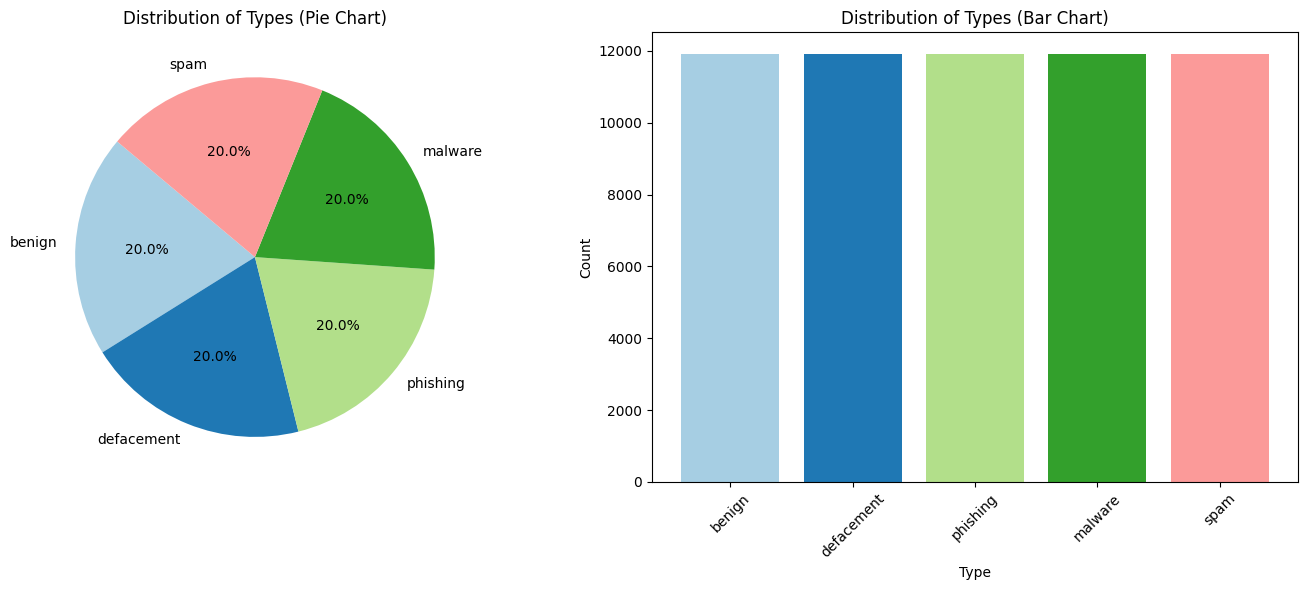

In [24]:
plot_type_distribution(df)

In [25]:
df.isna().sum()

url                          0
type                         0
scheme                       0
domain                       0
subdomain                    0
top_level_domain             0
path                         0
path_length                  0
num_path_segments            0
query_params                 0
num_query_params             0
has_https                    0
file_extension               0
has_fragment                 0
has_special_chars_in_path    0
has_port                     0
port_number                  0
is_ip_address                0
dtype: int64

In [26]:
df.to_csv('./Data/Balanced_dataset.csv', index=False)

C:\Users\Areeba\AppData\Local\Temp\ipykernel_12956\2899653271.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_correlation.index, y=target_correlation.values, palette="coolwarm")


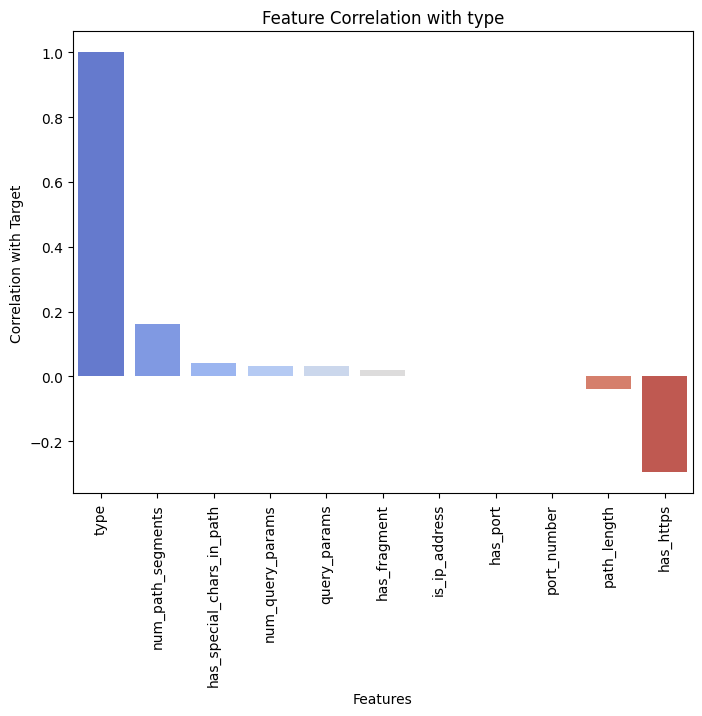

In [35]:
from sklearn.preprocessing import LabelEncoder

target_column = 'type'

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df[target_column])
df[target_column] = y_encoded

df2 = df.drop(['url', 'scheme', 'domain', 'subdomain', 'top_level_domain', 'path', 'file_extension'], axis=1)

target_correlation = df2.corr()[target_column].sort_values(ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(x=target_correlation.index, y=target_correlation.values, palette="coolwarm")
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("Correlation with Target")
plt.title(f"Feature Correlation with {target_column}")
plt.show()